In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sn
from IPython.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio


from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150


In [2]:
def load_dataset_from_structure(root_path):
    data = []
    for file in root_path.glob('*/*/*.csv'):
        try:
            df = pd.read_csv(file)

            category = file.parents[1].name  # DDoS, DoS, etc.
            attack = file.parent.name        # DDoS ICMP, DoS TCP, etc.
            label_class = 'Benign' if category.upper() == 'BENIGN' else 'Attack'

            df['category'] = category
            df['attack'] = attack
            df['class'] = label_class

            data.append(df)
        except Exception as e:
            print(f"[ERROR] Failed to read file {file}: {e}")
    return pd.concat(data, ignore_index=True)

# Load train
train_root = Path('../../../Data/CICIoMT2024/train')
train_df = load_dataset_from_structure(train_root)

# Load test
test_root = Path('../../../Data/CICIoMT2024/test')
test_df = load_dataset_from_structure(test_root)

# Cek ringkasan
print("Train set:", train_df.shape)
print(train_df[['category', 'attack', 'class']].value_counts())
print("\nTest set:", test_df.shape)
print(test_df[['category', 'attack', 'class']].value_counts())

# Gabungkan train dan test menjadi satu DataFrame
df = pd.concat([train_df, test_df], ignore_index=True)

Train set: (7160831, 48)
category  attack              class 
DDoS      DDoS UDP            Attack    1635956
          DDoS ICMP           Attack    1537476
          DDoS TCP            Attack     804465
          DDoS SYN            Attack     801962
DoS       DoS UDP             Attack     566950
          DoS SYN             Attack     441903
          DoS ICMP            Attack     416292
          DoS TCP             Attack     380384
BENIGN    BENIGN              Benign     192732
MQTT      DDoS Connect Flood  Attack     173036
RECON     Port Scan           Attack      83981
MQTT      DoS Publish Flood   Attack      44376
          DDoS Publish Flood  Attack      27623
RECON     OS Scan             Attack      16832
SPOOFING  SPOOFING            Attack      16047
MQTT      DoS Connect Flood   Attack      12773
          Malformed Data      Attack       5130
RECON     Recon VulScan       Attack       2173
          Ping Sweep          Attack        740
Name: count, dtype: int64


In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
# Encode label (binary: Attack/Benign)
le = LabelEncoder()
y_encoded = le.fit_transform(df['category'])
y_label = to_categorical(y_encoded)

# Features
X = df.drop(['class', 'category', 'attack'], axis=1, errors='ignore').select_dtypes(include=[np.number])
scaler = StandardScaler()
X_label = scaler.fit_transform(X)

In [4]:
# 4. Split data
X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(
    X_label, y_label, test_size=0.2, random_state=45
)

# 5. Bangun dan latih model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential([
    Input(shape=(X_train_label.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_label.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('dnn_model_label.keras', save_best_only=True)

# Training
history = model.fit(
    X_train_label, y_train_label,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

# Evaluasi
loss, accuracy = model.evaluate(X_test_label, y_test_label)
print(f"Akurasi: {accuracy:.4f}")


Epoch 1/20
87751/87751 ━━━━━━━━━━━━━━━━━━━━ 168s 2ms/step - accuracy: 0.7784 - loss: 0.4921 - val_accuracy: 0.7943 - val_loss: 0.4492
Epoch 2/20
87751/87751 ━━━━━━━━━━━━━━━━━━━━ 161s 2ms/step - accuracy: 0.7918 - loss: 0.4586 - val_accuracy: 0.7955 - val_loss: 0.4476
Epoch 3/20
87751/87751 ━━━━━━━━━━━━━━━━━━━━ 165s 2ms/step - accuracy: 0.7931 - loss: 0.4568 - val_accuracy: 0.7966 - val_loss: 0.4448
Epoch 4/20
87751/87751 ━━━━━━━━━━━━━━━━━━━━ 161s 2ms/step - accuracy: 0.7940 - loss: 0.4561 - val_accuracy: 0.7968 - val_loss: 0.4431
Epoch 5/20
87751/87751 ━━━━━━━━━━━━━━━━━━━━ 162s 2ms/step - accuracy: 0.7951 - loss: 0.4541 - val_accuracy: 0.7986 - val_loss: 0.4421
Epoch 6/20
87751/87751 ━━━━━━━━━━━━━━━━━━━━ 165s 2ms/step - accuracy: 0.7958 - loss: 0.4536 - val_accuracy: 0.8004 - val_loss: 0.4262
Epoch 7/20
87751/87751 ━━━━━━━━━━━━━━━━━━━━ 153s 2ms/step - accuracy: 0.7964 - loss: 0.4535 - val_accuracy: 0.7993 - val_loss: 0.4402
Epoch 8/20
87751/87751 ━━━━━━━━━━━━━━━━━━━━ 153s 2ms/step - ac

54844/54844 ━━━━━━━━━━━━━━━━━━━━ 46s 842us/step
              precision    recall  f1-score       support
BENIGN         0.902825  0.988702  0.943814  4.602600e+04
DDoS           0.864039  0.984397  0.920299  1.168892e+06
DoS            0.935471  0.593629  0.726339  4.453120e+05
MQTT           0.998375  0.982142  0.990192  6.506900e+04
RECON          0.999661  0.902229  0.948449  2.615300e+04
SPOOFING       0.530376  0.400732  0.456529  3.551000e+03
accuracy       0.882868  0.882868  0.882868  8.828680e-01
macro avg      0.871791  0.808639  0.830937  1.755003e+06
weighted avg   0.889508  0.882868  0.873773  1.755003e+06


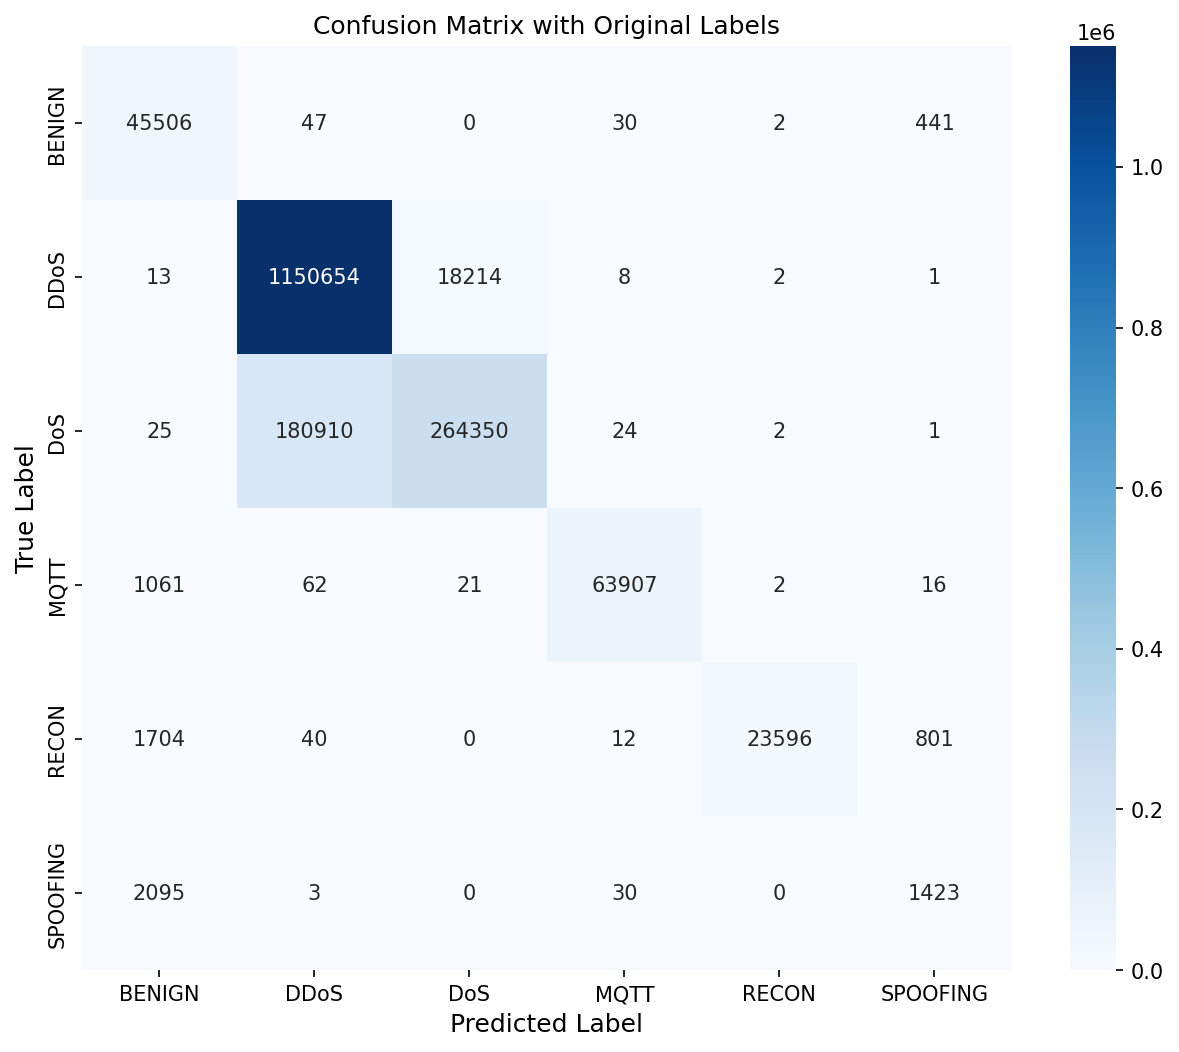

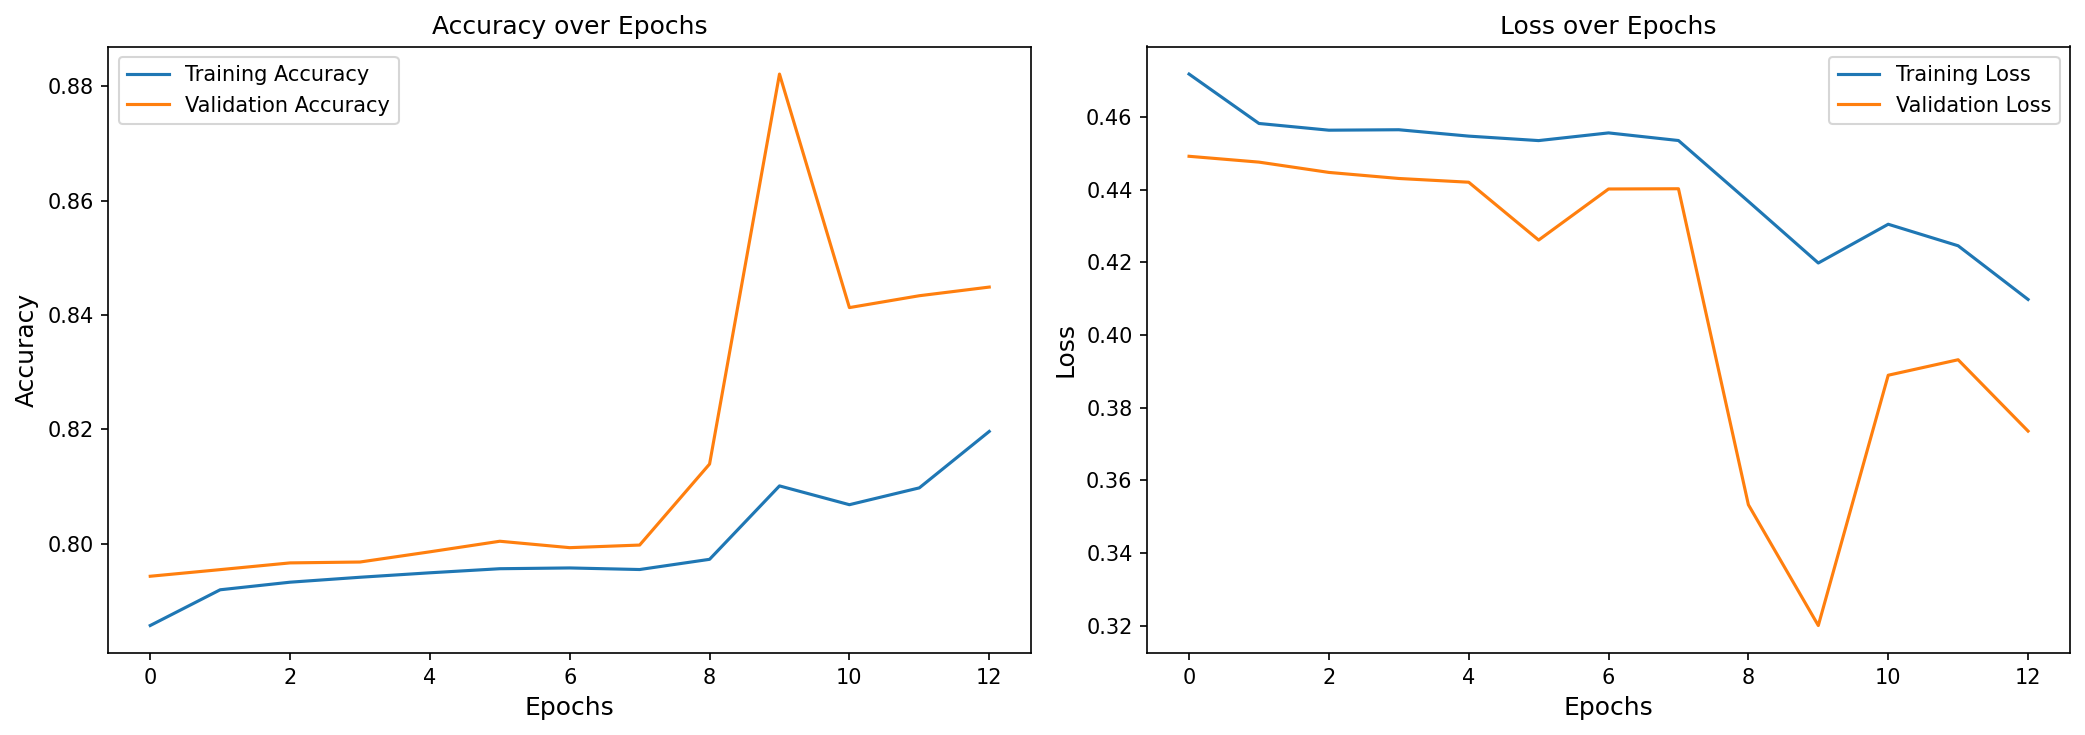

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded_label = le.fit_transform(df['category'])  # hasil numerik
y_label = to_categorical(y_encoded_label)  # one-hot (untuk model DNN)
# Prediksi model (output numerik)
y_pred = np.argmax(model.predict(X_test_label), axis=1)
y_true = np.argmax(y_test_label, axis=1)

# Ubah dari angka ke string label (asli)
y_pred_labels = le.inverse_transform(y_pred)
y_true_labels = le.inverse_transform(y_true)

from sklearn.metrics import classification_report

report = classification_report(y_true_labels, y_pred_labels, digits=5, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Buat confusion matrix dengan label karakter
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=le.classes_)

# Visualisasikan
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Original Labels')
plt.show()

# Visualisasi Akurasi dan Loss
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot Akurasi
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Accuracy over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot Loss
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Loss over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()
